In [2]:
import xarray as xr
import xmitgcm
import xgcm
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import ipywidgets
import dask
import cmocean
import pandas as pd

import gsw

# Initialise Cluster

In [146]:
# set up a larger cluster
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=16,memory="47GB", walltime='02:00:00')



/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41757 instead
  warnings.warn(


In [147]:
# either way, run this
client = Client(cluster)


In [148]:
# use to expand cluster as needed - ONLY IF USING A LARGER CLUSTER
cluster.scale(cores=32)

In [154]:
print(client)

<Client: 'tcp://10.0.128.133:38865' processes=8 threads=32, memory=87.52 GiB>


In [214]:
!squeue


             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
             44314      main dask-wor   jm1356 PD       0:00      1 (QOSMaxCpuPerUserLimit)
             44172      main dask-wor   ed7737  R    1:25:25      1 ood-n11
             44173      main dask-wor   ed7737  R    1:25:25      1 ood-n12
             44306      main dask-wor   jm1356  R       3:09      1 ood-n14
             44307      main dask-wor   jm1356  R       2:39      1 ood-n22
             44308      main dask-wor   jm1356  R       2:39      1 ood-n15
             44309      main dask-wor   jm1356  R       2:39      1 ood-n16
             44310      main dask-wor   jm1356  R       2:39      1 ood-n17
             44311      main dask-wor   jm1356  R       2:39      1 ood-n18
             44312      main dask-wor   jm1356  R       2:39      1 ood-n19
             44313      main dask-wor   jm1356  R       2:39      1 ood-n20
             44101       vdi sys/dash   jz6791 PD       0:00   

# Load datasets

In [12]:
model_dir = '/g/data/jk72/ed7737/SO-channel_embayment/simulations/run/'

In [13]:
iters = [5599584, 5600448, 5601312, 5602176, 5603040, 5603904,
5604768, 5605632, 5606496, 5607360, 5608224, 5609088,
5609952, 5610816, 5611680, 5612544, 5613408,
5614272, 5615136, 5616000, 5616864, 5617728, 5618592,
5619456, 5620320, 5621184, 5622048, 5622912,
5623776, 5624640, 5625504, 5626368, 5627232, 5628096,
5628960, 5629824, 5630688, 5631552, 5632416,
5633280, 5634144, 5635008, 5635872, 5636736, 5637600,
5638464, 5639328, 5640192, 5641056, 5641920,
5642784, 5643648, 5644512, 5645376, 5646240, 5647104,
5647968, 5648832, 5649696, 5650560, 5651424,
5652288, 5653152, 5654016, 5654880, 5655744, 5656608,
5657472, 5658336, 5659200, 5660064, 5660928,
5661792, 5662656, 5663520, 5664384, 5665248, 5666112,
5666976, 5667840, 5668704, 5669568, 5670432,
5671296, 5672160, 5673024, 5673888, 5674752, 5675616,
5676480, 5677344, 5678208, 5679072, 5679936,
5680800, 5681664, 5682528, 5683392, 5684256, 5685120,
5685984, 5686848, 5687712, 5688576, 5689440,
5690304, 5691168, 5692032, 5692896, 5693760, 5694624,
5695488, 5696352, 5697216, 5698080, 5698944,
5699808, 5700672, 5701536, 5702400, 5703264, 5704128,
5704992, 5705856, 5706720, 5707584, 5708448,
5709312, 5710176, 5711040, 5711904, 5712768, 5713632,
5714496, 5715360, 5716224, 5717088, 5717952,
5718816, 5719680, 5720544, 5721408, 5722272, 5723136,
5724000, 5724864, 5725728, 5726592, 5727456,
5728320, 5729184, 5730048, 5730912, 5731776, 5732640,
5733504, 5734368, 5735232, 5736096, 5736960,
5737824, 5738688, 5739552, 5740416, 5741280, 5742144,
5743008, 5743872, 5744736, 5745600, 5746464,
5747328, 5748192, 5749056, 5749920, 5750784, 5751648,
5752512, 5753376, 5754240, 5755104, 5755968,
5756832, 5757696, 5758560, 5759424, 5760288, 5761152,
5762016, 5762880, 5763744, 5764608, 5765472,
5766336, 5767200, 5768064, 5768928, 5769792, 5770656,
5771520, 5772384, 5773248, 5774112, 5774976,
5775840, 5776704, 5777568, 5778432, 5779296, 5780160,
5781024, 5781888, 5782752, 5783616, 5784480,
5785344, 5786208, 5787072, 5787936, 5788800, 5789664,
5790528, 5791392, 5792256, 5793120, 5793984,
5794848, 5795712, 5796576, 5797440, 5798304, 5799168,
5800032, 5800896, 5801760, 5802624, 5803488,
5804352, 5805216, 5806080, 5806944, 5807808, 5808672,
5809536, 5810400, 5811264, 5812128, 5812992,
5813856, 5814720, 5815584, 5816448, 5817312, 5818176,
5819040, 5819904, 5820768, 5821632, 5822496,
5823360, 5824224, 5825088, 5825952, 5826816, 5827680,
5828544, 5829408, 5830272, 5831136, 5832000,
5832864, 5833728, 5834592, 5835456, 5836320, 5837184,
5838048, 5838912, 5839776, 5840640, 5841504,
5842368, 5843232, 5844096, 5844960, 5845824, 5846688,
5847552, 5848416, 5849280, 5850144, 5851008,
5851872, 5852736, 5853600, 5854464, 5855328, 5856192,
5857056, 5857920, 5858784, 5859648, 5860512,
5861376, 5862240, 5863104, 5863968, 5864832, 5865696,
5866560, 5867424, 5868288, 5869152, 5870016,
5870880, 5871744, 5872608, 5873472, 5874336, 5875200,
5876064, 5876928, 5877792, 5878656, 5879520,
5880384, 5881248, 5882112, 5882976, 5883840, 5884704,
5885568, 5886432, 5887296, 5888160, 5889024,
5889888, 5890752, 5891616, 5892480, 5893344, 5894208,
5895072, 5895936, 5896800, 5897664, 5898528,
5899392, 5900256, 5901120, 5901984, 5902848, 5903712,
5904576, 5905440, 5906304, 5907168, 5908032,
5908896, 5909760, 5910624, 5911488, 5912352, 5913216,
5914080, 5914944, 5915808, 5916672, 5917536,
5918400, 5919264, 5920128, 5920992, 5921856, 5922720,
5923584, 5924448, 5925312, 5926176, 5927040,
5927904, 5928768, 5929632, 5930496, 5931360, 5932224,
5933088, 5933952, 5934816, 5935680, 5936544,
5937408, 5938272, 5939136, 5940000, 5940864, 5941728,
5942592, 5943456, 5944320, 5945184, 5946048,
5946912, 5947776, 5948640, 5949504, 5950368, 5951232,
5952096, 5952960, 5953824, 5954688, 5955552,
5956416, 5957280, 5958144, 5959008, 5959872, 5960736,
5961600, 5962464, 5963328, 5964192, 5965056,
5965920, 5966784, 5967648, 5968512, 5969376, 5970240,
5971104, 5971968, 5972832, 5973696, 5974560,
5975424, 5976288, 5977152, 5978016, 5978880, 5979744,
5980608, 5981472, 5982336, 5983200, 5984064,
5984928, 5985792, 5986656, 5987520, 5988384, 5989248,
5990112, 5990976, 5991840, 5992704, 5993568,
5994432, 5995296, 5996160, 5997024, 5997888, 5998752,
5999616, 6000480, 6001344, 6002208, 6003072,
6003936, 6004800, 6005664, 6006528, 6007392, 6008256,
6009120, 6009984, 6010848, 6011712, 6012576,
6013440, 6014304, 6015168, 6016032, 6016896, 6017760,
6018624, 6019488, 6020352, 6021216, 6022080,
6022944, 6023808, 6024672, 6025536, 6026400, 6027264,
6028128, 6028992, 6029856, 6030720, 6031584,
6032448, 6033312, 6034176, 6035040, 6035904, 6036768,
6037632, 6038496, 6039360, 6040224, 6041088,
6041952, 6042816, 6043680, 6044544, 6045408, 6046272,
6047136, 6048000, 6048864, 6049728, 6050592,
6051456, 6052320, 6053184, 6054048, 6054912, 6055776,
6056640, 6057504, 6058368, 6059232, 6060096,
6060960, 6061824, 6062688, 6063552, 6064416, 6065280,
6066144, 6067008, 6067872, 6068736, 6069600,
6070464, 6071328, 6072192, 6073056, 6073920, 6074784,
6075648, 6076512, 6077376, 6078240, 6079104,
6079968, 6080832, 6081696, 6082560, 6083424, 6084288,
6085152, 6086016, 6086880, 6087744, 6088608,
6089472, 6090336, 6091200, 6092064, 6092928, 6093792,
6094656, 6095520, 6096384, 6097248, 6098112,
6098976, 6099840, 6100704, 6101568, 6102432, 6103296,
6104160, 6105024, 6105888, 6106752, 6107616,
6108480, 6109344, 6110208, 6111072, 6111936, 6112800,
6113664, 6114528, 6115392, 6116256, 6117120,
6117984, 6118848, 6119712, 6120576, 6121440, 6122304,
6123168, 6124032, 6124896, 6125760, 6126624,
6127488, 6128352, 6129216, 6130080, 6130944, 6131808,
6132672, 6133536, 6134400, 6135264, 6136128,
6136992, 6137856, 6138720, 6139584, 6140448, 6141312,
6142176, 6143040, 6143904, 6144768, 6145632,
6146496, 6147360, 6148224, 6149088, 6149952, 6150816,
6151680, 6152544, 6153408, 6154272, 6155136,
6156000, 6156864, 6157728, 6158592, 6159456, 6160320,
6161184, 6162048, 6162912, 6163776, 6164640,
6165504, 6166368, 6167232, 6168096, 6168960, 6169824,
6170688, 6171552, 6172416, 6173280, 6174144,
6175008, 6175872, 6176736, 6177600, 6178464, 6179328,
6180192, 6181056, 6181920, 6182784, 6183648,
6184512, 6185376, 6186240, 6187104, 6187968, 6188832,
6189696, 6190560, 6191424, 6192288, 6193152,
6194016, 6194880, 6195744, 6196608, 6197472, 6198336,
6199200, 6200064, 6200928, 6201792, 6202656,
6203520, 6204384, 6205248, 6206112, 6206976, 6207840,
6208704, 6209568, 6210432, 6211296, 6212160,
6213024, 6213888, 6214752, 6215616, 6216480, 6217344,
6218208, 6219072, 6219936, 6220800, 6221664,
6222528, 6223392, 6224256, 6225120, 6225984, 6226848,
6227712, 6228576, 6229440, 6230304, 6231168,
6232032, 6232896, 6233760, 6234624, 6235488, 6236352,
6237216, 6238080, 6238944, 6239808, 6240672,
6241536, 6242400, 6243264, 6244128, 6244992, 6245856,
6246720, 6247584, 6248448, 6249312, 6250176,
6251040, 6251904, 6252768, 6253632, 6254496, 6255360,
6256224, 6257088, 6257952, 6258816, 6259680,
6260544, 6261408, 6262272, 6263136, 6264000, 6264864,
6265728, 6266592, 6267456, 6268320, 6269184,
6270048, 6270912, 6271776, 6272640, 6273504, 6274368,
6275232, 6276096, 6276960, 6277824, 6278688,
6279552, 6280416, 6281280, 6282144, 6283008, 6283872,
6284736, 6285600, 6286464, 6287328, 6288192,
6289056, 6289920, 6290784, 6291648, 6292512, 6293376,
6294240, 6295104, 6295968, 6296832, 6297696,
6298560, 6299424, 6300288, 6301152, 6302016, 6302880,
6303744, 6304608, 6305472, 6306336, 6307200,
6308064, 6308928, 6309792, 6310656, 6311520, 6312384,
6313248, 6314112, 6314976, 6315840, 6316704,
6317568, 6318432, 6319296, 6320160, 6321024, 6321888,
6322752, 6323616, 6324480, 6325344, 6326208,
6327072, 6327936, 6328800, 6329664, 6330528, 6331392,
6332256, 6333120, 6333984, 6334848, 6335712,
6336576, 6337440, 6338304, 6339168, 6340032, 6340896,
6341760, 6342624, 6343488, 6344352, 6345216,
6346080, 6346944, 6347808, 6348672, 6349536, 6350400,
6351264, 6352128, 6352992, 6353856, 6354720,
6355584, 6356448, 6357312, 6358176, 6359040, 6359904,
6360768, 6361632, 6362496, 6363360, 6364224,
6365088, 6365952, 6366816, 6367680, 6368544, 6369408,
6370272, 6371136, 6372000, 6372864, 6373728,
6374592, 6375456, 6376320, 6377184, 6378048, 6378912,
6379776, 6380640, 6381504, 6382368, 6383232,
6384096, 6384960, 6385824, 6386688, 6387552, 6388416,
6389280, 6390144, 6391008, 6391872, 6392736,
6393600, 6394464, 6395328, 6396192, 6397056, 6397920,
6398784, 6399648, 6400512, 6401376, 6402240,
6403104, 6403968, 6404832, 6405696, 6406560, 6407424,
6408288, 6409152, 6410016, 6410880, 6411744,
6412608, 6413472, 6414336, 6415200, 6416064, 6416928,
6417792, 6418656, 6419520, 6420384, 6421248,
6422112, 6422976, 6423840, 6424704, 6425568, 6426432,
6427296, 6428160, 6429024, 6429888, 6430752,
6431616, 6432480, 6433344, 6434208, 6435072, 6435936,
6436800, 6437664, 6438528, 6439392, 6440256,
6441120, 6441984, 6442848, 6443712, 6444576, 6445440,
6446304, 6447168, 6448032, 6448896, 6449760,
6450624, 6451488, 6452352, 6453216, 6454080, 6454944,
6455808, 6456672, 6457536, 6458400, 6459264,
6460128, 6460992, 6461856, 6462720, 6463584, 6464448,
6465312, 6466176, 6467040, 6467904, 6468768,
6469632, 6470496, 6471360, 6472224, 6473088, 6473952,
6474816, 6475680, 6476544, 6477408, 6478272,
6479136, 6480000, 6480864, 6481728, 6482592, 6483456,
6484320, 6485184, 6486048, 6486912, 6487776,
6488640, 6489504, 6490368, 6491232, 6492096, 6492960,
6493824, 6494688, 6495552, 6496416, 6497280,
6498144, 6499008, 6499872, 6500736, 6501600, 6502464,
6503328, 6504192, 6505056, 6505920, 6506784,
6507648, 6508512, 6509376, 6510240, 6511104, 6511968,
6512832, 6513696, 6514560, 6515424, 6516288,
6517152, 6518016, 6518880, 6519744, 6520608, 6521472,
6522336, 6523200, 6524064, 6524928, 6525792,
6526656, 6527520, 6528384, 6529248, 6530112, 6530976,
6531840, 6532704, 6533568, 6534432, 6535296,
6536160, 6537024, 6537888, 6538752, 6539616, 6540480,
6541344, 6542208, 6543072, 6543936, 6544800,
6545664, 6546528, 6547392, 6548256, 6549120, 6549984,
6550848, 6551712, 6552576, 6553440, 6554304,
6555168, 6556032, 6556896, 6557760, 6558624, 6559488,
6560352, 6561216, 6562080, 6562944, 6563808,
6564672, 6565536, 6566400, 6567264, 6568128, 6568992,
6569856, 6570720, 6571584, 6572448, 6573312,
6574176, 6575040, 6575904, 6576768, 6577632, 6578496,
6579360, 6580224, 6581088, 6581952, 6582816,
6583680, 6584544, 6585408, 6586272, 6587136, 6588000,
6588864, 6589728, 6590592, 6591456, 6592320,
6593184, 6594048, 6594912, 6595776, 6596640, 6597504,
6598368, 6599232, 6600096, 6600960, 6601824,
6602688, 6603552, 6604416, 6605280, 6606144, 6607008,
6607872, 6608736, 6609600, 6610464, 6611328,
6612192, 6613056, 6613920, 6614784, 6615648, 6616512,
6617376, 6618240, 6619104, 6619968, 6620832,
6621696, 6622560, 6623424, 6624288, 6625152, 6626016,
6626880, 6627744, 6628608, 6629472, 6630336,
6631200, 6632064, 6632928, 6633792, 6634656, 6635520,
6636384, 6637248, 6638112, 6638976, 6639840,
6640704, 6641568, 6642432, 6643296, 6644160, 6645024,
6645888, 6646752, 6647616, 6648480, 6649344,
6650208, 6651072, 6651936, 6652800, 6653664, 6654528,
6655392, 6656256, 6657120, 6657984, 6658848,
6659712, 6660576, 6661440, 6662304, 6663168, 6664032,
6664896, 6665760, 6666624, 6667488, 6668352,
6669216, 6670080, 6670944, 6671808, 6672672, 6673536,
6674400, 6675264, 6676128, 6676992, 6677856,
6678720, 6679584, 6680448, 6681312, 6682176, 6683040,
6683904, 6684768, 6685632, 6686496, 6687360,
6688224, 6689088, 6689952, 6690816, 6691680, 6692544,
6693408, 6694272, 6695136, 6696000, 6696864,
6697728, 6698592, 6699456, 6700320, 6701184, 6702048,
6702912, 6703776, 6704640, 6705504, 6706368,
6707232, 6708096, 6708960, 6709824, 6710688, 6711552,
6712416, 6713280, 6714144, 6715008, 6715872,
6716736, 6717600, 6718464, 6719328, 6720192, 6721056,
6721920, 6722784, 6723648, 6724512, 6725376,
6726240, 6727104, 6727968, 6728832, 6729696, 6730560,
6731424, 6732288, 6733152, 6734016, 6734880,
6735744, 6736608, 6737472, 6738336, 6739200, 6740064,
6740928, 6741792, 6742656, 6743520, 6744384,
6745248, 6746112, 6746976, 6747840, 6748704, 6749568,
6750432, 6751296, 6752160, 6753024, 6753888,
6754752, 6755616, 6756480, 6757344, 6758208, 6759072,
6759936, 6760800, 6761664, 6762528, 6763392,
6764256, 6765120, 6765984, 6766848, 6767712, 6768576,
6769440, 6770304, 6771168, 6772032, 6772896,
6773760, 6774624, 6775488, 6776352, 6777216, 6778080,
6778944, 6779808, 6780672, 6781536, 6782400,
6783264, 6784128, 6784992, 6785856, 6786720, 6787584,
6788448, 6789312, 6790176, 6791040, 6791904,
6792768, 6793632, 6794496, 6795360, 6796224, 6797088,
6797952, 6798816, 6799680, 6800544, 6801408,
6802272, 6803136, 6804000, 6804864, 6805728, 6806592,
6807456, 6808320, 6809184, 6810048, 6810912,
6811776, 6812640, 6813504, 6814368, 6815232, 6816096,
6816960, 6817824, 6818688, 6819552, 6820416,
6821280, 6822144, 6823008, 6823872, 6824736, 6825600,
6826464, 6827328, 6828192, 6829056, 6829920,
6830784, 6831648, 6832512, 6833376, 6834240, 6835104,
6835968, 6836832, 6837696, 6838560, 6839424,
6840288, 6841152, 6842016, 6842880, 6843744, 6844608,
6845472, 6846336, 6847200, 6848064, 6848928,
6849792, 6850656, 6851520, 6852384, 6853248, 6854112,
6854976, 6855840, 6856704, 6857568, 6858432,
6859296, 6860160, 6861024, 6861888, 6862752, 6863616,
6864480, 6865344, 6866208, 6867072, 6867936,
6868800, 6869664, 6870528, 6871392, 6872256, 6873120,
6873984, 6874848, 6875712, 6876576, 6877440,
6878304, 6879168, 6880032, 6880896, 6881760, 6882624,
6883488, 6884352, 6885216, 6886080, 6886944,
6887808, 6888672, 6889536, 6890400, 6891264, 6892128,
6892992, 6893856, 6894720, 6895584, 6896448,
6897312, 6898176, 6899040, 6899904, 6900768, 6901632,
6902496, 6903360, 6904224, 6905088, 6905952,
6906816, 6907680, 6908544, 6909408, 6910272, 6911136,
6912000, 6912864, 6913728, 6914592, 6915456,
6916320, 6917184, 6918048, 6918912, 6919776, 6920640,
6921504, 6922368, 6923232, 6924096, 6924960,
6925824, 6926688, 6927552, 6928416, 6929280, 6930144,
6931008, 6931872, 6932736, 6933600, 6934464,
6935328, 6936192, 6937056, 6937920, 6938784, 6939648,
6940512, 6941376, 6942240, 6943104, 6943968,
6944832, 6945696, 6946560, 6947424, 6948288, 6949152,
6950016, 6950880, 6951744, 6952608, 6953472,
6954336, 6955200, 6956064, 6956928, 6957792, 6958656,
6959520, 6960384, 6961248, 6962112, 6962976,
6963840, 6964704, 6965568, 6966432, 6967296, 6968160,
6969024, 6969888, 6970752, 6971616, 6972480,
6973344, 6974208, 6975072, 6975936, 6976800, 6977664,
6978528, 6979392, 6980256, 6981120, 6981984,
6982848, 6983712, 6984576, 6985440, 6986304, 6987168,
6988032, 6988896, 6989760, 6990624, 6991488,
6992352, 6993216, 6994080, 6994944, 6995808, 6996672,
6997536, 6998400, 6999264, 7000128, 7000992,
7001856, 7002720, 7003584, 7004448, 7005312, 7006176,
7007040, 7007904, 7008768, 7009632, 7010496,
7011360, 7012224, 7013088, 7013952, 7014816, 7015680,
7016544, 7017408, 7018272, 7019136, 7020000,
7020864, 7021728, 7022592, 7023456, 7024320, 7025184,
7026048, 7026912, 7027776, 7028640, 7029504,
7030368, 7031232, 7032096, 7032960, 7033824, 7034688,
7035552, 7036416, 7037280, 7038144, 7039008,
7039872, 7040736, 7041600, 7042464, 7043328, 7044192,
7045056, 7045920, 7046784, 7047648, 7048512,
7049376, 7050240, 7051104, 7051968, 7052832, 7053696,
7054560, 7055424, 7056288, 7057152, 7058016,
7058880, 7059744, 7060608, 7061472, 7062336, 7063200,
7064064, 7064928, 7065792, 7066656, 7067520,
7068384, 7069248, 7070112, 7070976, 7071840, 7072704,
7073568, 7074432, 7075296, 7076160, 7077024,
7077888, 7078752, 7079616, 7080480, 7081344, 7082208,
7083072, 7083936, 7084800, 7085664, 7086528,
7087392, 7088256, 7089120, 7089984, 7090848, 7091712,
7092576, 7093440, 7094304, 7095168, 7096032,
7096896, 7097760, 7098624, 7099488, 7100352, 7101216,
7102080, 7102944, 7103808, 7104672, 7105536,
7106400, 7107264, 7108128, 7108992, 7109856, 7110720,
7111584, 7112448, 7113312, 7114176, 7115040,
7115904, 7116768, 7117632, 7118496, 7119360, 7120224,
7121088, 7121952, 7122816, 7123680, 7124544,
7125408, 7126272, 7127136, 7128000, 7128864, 7129728,
7130592, 7131456, 7132320, 7133184, 7134048,
7134912, 7135776, 7136640, 7137504, 7138368, 7139232,
7140096, 7140960, 7141824, 7142688, 7143552,
7144416, 7145280, 7146144, 7147008, 7147872, 7148736,
7149600, 7150464, 7151328, 7152192, 7153056,
7153920, 7154784, 7155648, 7156512, 7157376, 7158240,
7159104, 7159968, 7160832, 7161696, 7162560,
7163424, 7164288, 7165152, 7166016, 7166880, 7167744,
7168608, 7169472, 7170336, 7171200, 7172064,
7172928, 7173792, 7174656, 7175520, 7176384, 7177248,
7178112, 7178976, 7179840, 7180704, 7181568,
7182432, 7183296, 7184160, 7185024, 7185888, 7186752,
7187616, 7188480, 7189344, 7190208, 7191072,
7191936, 7192800, 7193664, 7194528, 7195392, 7196256,
7197120, 7197984, 7198848, 7199712, 7200576,
7201440, 7202304, 7203168, 7204032, 7204896, 7205760,
7206624, 7207488, 7208352, 7209216, 7210080,
7210944, 7211808, 7212672, 7213536, 7214400, 7215264,
7216128, 7216992, 7217856, 7218720, 7219584,
7220448, 7221312, 7222176, 7223040, 7223904, 7224768,
7225632, 7226496, 7227360, 7228224, 7229088,
7229952, 7230816, 7231680, 7232544, 7233408, 7234272,
7235136, 7236000, 7236864, 7237728, 7238592,
7239456, 7240320, 7241184, 7242048, 7242912, 7243776,
7244640, 7245504, 7246368, 7247232, 7248096,
7248960, 7249824, 7250688, 7251552, 7252416, 7253280,
7254144, 7255008, 7255872, 7256736, 7257600,
7258464, 7259328, 7260192, 7261056, 7261920, 7262784,
7263648, 7264512, 7265376, 7266240, 7267104,
7267968, 7268832, 7269696, 7270560, 7271424, 7272288,
7273152, 7274016, 7274880, 7275744, 7276608,
7277472, 7278336, 7279200, 7280064, 7280928, 7281792,
7282656, 7283520, 7284384, 7285248, 7286112,
7286976, 7287840, 7288704, 7289568, 7290432, 7291296,
7292160, 7293024, 7293888, 7294752, 7295616,
7296480, 7297344, 7298208, 7299072, 7299936, 7300800,
7301664, 7302528, 7303392, 7304256, 7305120,
7305984, 7306848, 7307712, 7308576, 7309440, 7310304,
7311168, 7312032, 7312896, 7313760, 7314624,
7315488, 7316352, 7317216, 7318080, 7318944, 7319808,
7320672, 7321536, 7322400, 7323264, 7324128,
7324992, 7325856, 7326720, 7327584, 7328448, 7329312,
7330176, 7331040, 7331904, 7332768, 7333632,
7334496, 7335360, 7336224, 7337088, 7337952, 7338816,
7339680, 7340544, 7341408, 7342272, 7343136,
7344000, 7344864, 7345728, 7346592, 7347456, 7348320,
7349184, 7350048, 7350912, 7351776, 7352640,
7353504, 7354368, 7355232, 7356096, 7356960, 7357824,
7358688, 7359552, 7360416, 7361280, 7362144,
7363008, 7363872, 7364736, 7365600, 7366464, 7367328,
7368192, 7369056, 7369920, 7370784, 7371648,
7372512, 7373376, 7374240, 7375104, 7375968, 7376832,
7377696, 7378560, 7379424, 7380288, 7381152,
7382016, 7382880, 7383744, 7384608, 7385472, 7386336,
7387200, 7388064, 7388928, 7389792, 7390656,
7391520, 7392384, 7393248, 7394112, 7394976, 7395840,
7396704, 7397568, 7398432, 7399296, 7400160,
7401024, 7401888, 7402752, 7403616, 7404480, 7405344,
7406208, 7407072, 7407936, 7408800, 7409664,
7410528, 7411392, 7412256, 7413120, 7413984, 7414848,
7415712, 7416576, 7417440, 7418304, 7419168,
7420032, 7420896, 7421760, 7422624, 7423488, 7424352,
7425216, 7426080, 7426944, 7427808, 7428672,
7429536, 7430400, 7431264, 7432128, 7432992, 7433856,
7434720, 7435584, 7436448, 7437312, 7438176,
7439040, 7439904, 7440768, 7441632, 7442496, 7443360,
7444224, 7445088, 7445952, 7446816, 7447680,
7448544, 7449408, 7450272, 7451136, 7452000, 7452864,
7453728, 7454592, 7455456, 7456320, 7457184,
7458048, 7458912, 7459776, 7460640, 7461504, 7462368,
7463232, 7464096, 7464960, 7465824, 7466688,
7467552, 7468416, 7469280, 7470144, 7471008, 7471872,
7472736, 7473600, 7474464, 7475328, 7476192,
7477056, 7477920, 7478784, 7479648, 7480512, 7481376,
7482240, 7483104, 7483968, 7484832, 7485696,
7486560, 7487424, 7488288, 7489152, 7490016, 7490880,
7491744, 7492608, 7493472, 7494336, 7495200,
7496064, 7496928, 7497792, 7498656, 7499520, 7500384,
7501248, 7502112, 7502976, 7503840, 7504704,
7505568, 7506432, 7507296, 7508160, 7509024, 7509888,
7510752, 7511616, 7512480, 7513344, 7514208,
7515072, 7515936, 7516800, 7517664, 7518528, 7519392,
7520256, 7521120, 7521984, 7522848, 7523712,
7524576, 7525440, 7526304, 7527168, 7528032, 7528896,
7529760, 7530624, 7531488, 7532352, 7533216,
7534080, 7534944, 7535808, 7536672, 7537536, 7538400,
7539264, 7540128, 7540992, 7541856, 7542720,
7543584, 7544448, 7545312, 7546176, 7547040, 7547904,
7548768, 7549632, 7550496, 7551360, 7552224,
7553088, 7553952, 7554816, 7555680, 7556544, 7557408,
7558272, 7559136, 7560000, 7560864, 7561728,
7562592, 7563456, 7564320, 7565184, 7566048, 7566912,
7567776, 7568640, 7569504, 7570368, 7571232,
7572096, 7572960, 7573824, 7574688, 7575552, 7576416,
7577280, 7578144, 7579008, 7579872, 7580736,
7581600, 7582464, 7583328, 7584192, 7585056, 7585920,
7586784, 7587648, 7588512, 7589376, 7590240,
7591104, 7591968, 7592832, 7593696, 7594560, 7595424,
7596288, 7597152, 7598016, 7598880, 7599744,
7600608, 7601472, 7602336, 7603200, 7604064, 7604928,
7605792, 7606656, 7607520, 7608384, 7609248,
7610112, 7610976, 7611840, 7612704, 7613568, 7614432,
7615296, 7616160, 7617024, 7617888, 7618752,
7619616, 7620480, 7621344, 7622208, 7623072, 7623936,
7624800, 7625664, 7626528, 7627392, 7628256,
7629120, 7629984, 7630848, 7631712, 7632576, 7633440,
7634304, 7635168, 7636032, 7636896, 7637760,
7638624, 7639488, 7640352, 7641216, 7642080, 7642944,
7643808, 7644672, 7645536, 7646400, 7647264,
7648128, 7648992, 7649856, 7650720, 7651584, 7652448,
7653312, 7654176, 7655040, 7655904, 7656768,
7657632, 7658496, 7659360, 7660224, 7661088, 7661952,
7662816, 7663680, 7664544, 7665408, 7666272,
7667136, 7668000, 7668864, 7669728, 7670592, 7671456,
7672320, 7673184, 7674048, 7674912, 7675776,
7676640, 7677504, 7678368, 7679232, 7680096, 7680960,
7681824, 7682688, 7683552, 7684416, 7685280,
7686144, 7687008, 7687872, 7688736, 7689600, 7690464,
7691328, 7692192, 7693056, 7693920, 7694784,
7695648, 7696512, 7697376, 7698240, 7699104, 7699968,
7700832, 7701696, 7702560, 7703424, 7704288,
7705152, 7706016, 7706880, 7707744, 7708608, 7709472,
7710336, 7711200, 7712064, 7712928, 7713792,
7714656, 7715520, 7716384, 7717248, 7718112, 7718976,
7719840, 7720704, 7721568, 7722432, 7723296,
7724160, 7725024, 7725888, 7726752, 7727616, 7728480,
7729344, 7730208, 7731072, 7731936, 7732800,
7733664, 7734528, 7735392, 7736256, 7737120, 7737984,
7738848, 7739712, 7740576, 7741440, 7742304,
7743168, 7744032, 7744896, 7745760, 7746624, 7747488,
7748352, 7749216, 7750080, 7750944, 7751808,
7752672, 7753536, 7754400, 7755264, 7756128, 7756992,
7757856, 7758720, 7759584, 7760448, 7761312,
7762176, 7763040, 7763904, 7764768, 7765632, 7766496,
7767360, 7768224, 7769088, 7769952, 7770816,
7771680, 7772544, 7773408, 7774272, 7775136, 7776000,
7776864, 7777728, 7778592, 7779456, 7780320,
7781184, 7782048, 7782912, 7783776, 7784640, 7785504,
7786368, 7787232, 7788096, 7788960, 7789824,
7790688, 7791552, 7792416, 7793280, 7794144, 7795008,
7795872, 7796736, 7797600, 7798464, 7799328,
7800192, 7801056, 7801920, 7802784, 7803648, 7804512,
7805376, 7806240, 7807104, 7807968, 7808832,
7809696, 7810560, 7811424, 7812288, 7813152, 7814016,
7814880, 7815744, 7816608, 7817472, 7818336,
7819200, 7820064, 7820928, 7821792, 7822656, 7823520,
7824384, 7825248, 7826112, 7826976, 7827840,
7828704, 7829568, 7830432, 7831296, 7832160, 7833024,
7833888, 7834752, 7835616, 7836480, 7837344,
7838208, 7839072, 7839936, 7840800, 7841664, 7842528,
7843392, 7844256, 7845120, 7845984, 7846848,
7847712, 7848576, 7849440, 7850304, 7851168, 7852032,
7852896, 7853760, 7854624, 7855488, 7856352,
7857216, 7858080, 7858944, 7859808, 7860672, 7861536,
7862400, 7863264, 7864128, 7864992, 7865856,
7866720, 7867584, 7868448, 7869312, 7870176, 7871040,
7871904, 7872768, 7873632, 7874496, 7875360,
7876224, 7877088, 7877952, 7878816, 7879680, 7880544,
7881408, 7882272, 7883136, 7884000, 7884864,
7885728, 7886592, 7887456, 7888320, 7889184, 7890048,
7890912, 7891776, 7892640, 7893504, 7894368,
7895232, 7896096, 7896960, 7897824, 7898688, 7899552,
7900416, 7901280, 7902144, 7903008, 7903872,
7904736, 7905600, 7906464, 7907328, 7908192, 7909056,
7909920, 7910784, 7911648, 7912512, 7913376,
7914240, 7915104, 7915968, 7916832, 7917696, 7918560,
7919424, 7920288, 7921152, 7922016, 7922880,
7923744, 7924608, 7925472, 7926336, 7927200, 7928064,
7928928, 7929792, 7930656, 7931520, 7932384,
7933248, 7934112, 7934976, 7935840, 7936704, 7937568,
7938432, 7939296, 7940160, 7941024, 7941888,
7942752, 7943616, 7944480, 7945344, 7946208, 7947072,
7947936, 7948800, 7949664, 7950528, 7951392,
7952256, 7953120, 7953984, 7954848, 7955712, 7956576,
7957440, 7958304, 7959168, 7960032, 7960896,
7961760, 7962624, 7963488, 7964352, 7965216, 7966080,
7966944, 7967808, 7968672, 7969536, 7970400,
7971264, 7972128, 7972992, 7973856, 7974720, 7975584,
7976448, 7977312, 7978176, 7979040, 7979904,
7980768, 7981632, 7982496, 7983360, 7984224, 7985088,
7985952, 7986816, 7987680, 7988544, 7989408,
7990272, 7991136, 7992000, 7992864, 7993728, 7994592,
7995456, 7996320, 7997184, 7998048, 7998912,
7999776, 8000640, 8001504, 8002368, 8003232, 8004096,
8004960, 8005824, 8006688, 8007552, 8008416,
8009280, 8010144, 8011008, 8011872, 8012736, 8013600,
8014464, 8015328, 8016192, 8017056, 8017920,
8018784, 8019648, 8020512, 8021376, 8022240, 8023104,
8023968, 8024832, 8025696, 8026560, 8027424,
8028288, 8029152, 8030016, 8030880, 8031744, 8032608,
8033472, 8034336, 8035200, 8036064, 8036928,
8037792, 8038656, 8039520, 8040384, 8041248, 8042112,
8042976, 8043840, 8044704, 8045568, 8046432,
8047296, 8048160, 8049024, 8049888, 8050752, 8051616,
8052480, 8053344, 8054208, 8055072, 8055936,
8056800, 8057664, 8058528, 8059392, 8060256, 8061120,
8061984, 8062848, 8063712, 8064576, 8065440,
8066304, 8067168, 8068032, 8068896, 8069760, 8070624,
8071488, 8072352, 8073216, 8074080, 8074944,
8075808, 8076672, 8077536, 8078400, 8079264, 8080128,
8080992, 8081856, 8082720, 8083584, 8084448,
8085312, 8086176, 8087040, 8087904, 8088768, 8089632,
8090496, 8091360, 8092224, 8093088, 8093952,
8094816, 8095680, 8096544, 8097408, 8098272, 8099136,
8100000, 8100864, 8101728, 8102592, 8103456,
8104320, 8105184, 8106048, 8106912, 8107776, 8108640,
8109504, 8110368, 8111232, 8112096, 8112960,
8113824, 8114688, 8115552, 8116416, 8117280, 8118144,
8119008, 8119872, 8120736, 8121600, 8122464,
8123328, 8124192, 8125056, 8125920, 8126784, 8127648,
8128512, 8129376, 8130240, 8131104, 8131968,
8132832, 8133696, 8134560, 8135424, 8136288, 8137152,
8138016, 8138880, 8139744, 8140608, 8141472,
8142336, 8143200, 8144064, 8144928, 8145792, 8146656,
8147520, 8148384, 8149248, 8150112, 8150976,
8151840, 8152704, 8153568, 8154432, 8155296, 8156160,
8157024, 8157888, 8158752, 8159616, 8160480,
8161344, 8162208, 8163072, 8163936, 8164800, 8165664,
8166528, 8167392, 8168256, 8169120, 8169984,
8170848, 8171712, 8172576, 8173440, 8174304, 8175168,
8176032, 8176896, 8177760, 8178624, 8179488,
8180352, 8181216, 8182080, 8182944, 8183808, 8184672,
8185536, 8186400, 8187264, 8188128, 8188992,
8189856, 8190720, 8191584, 8192448, 8193312, 8194176,
8195040, 8195904, 8196768, 8197632, 8198496,
8199360, 8200224, 8201088, 8201952, 8202816, 8203680,
8204544, 8205408, 8206272, 8207136, 8208000,
8208864, 8209728, 8210592, 8211456, 8212320, 8213184,
8214048, 8214912, 8215776, 8216640, 8217504,
8218368, 8219232, 8220096, 8220960, 8221824, 8222688,
8223552, 8224416, 8225280, 8226144, 8227008,
8227872, 8228736, 8229600, 8230464, 8231328, 8232192,
8233056, 8233920, 8234784, 8235648, 8236512,
8237376, 8238240, 8239104, 8239968, 8240832, 8241696,
8242560, 8243424, 8244288, 8245152, 8246016,
8246880, 8247744, 8248608, 8249472, 8250336]

In [14]:
iters = iters[-720:]
len(iters)

720

In [15]:
ds_2d = xmitgcm.open_mdsdataset(data_dir=model_dir+'/Diags', grid_dir=model_dir,
                                prefix=['2D_diags'], delta_t=500, calendar='360_day',
                                ref_date='2000-1-1 0:0:0', geometry='Cartesian',
                               iters=iters)

In [16]:
ds_seaice = xmitgcm.open_mdsdataset(data_dir=model_dir+'/Diags', grid_dir=model_dir,
                                    prefix=['seaIceDiag'], delta_t=500, calendar='360_day',
                                    ref_date='2000-1-1 0:0:0', geometry='Cartesian',
                               iters=iters)

In [17]:
ds_heat = xmitgcm.open_mdsdataset(data_dir=model_dir+'/Diags', grid_dir=model_dir,
                                      prefix=['heat_3D'], delta_t=500, calendar='360_day',
                                      ref_date='2000-1-1 0:0:0', geometry='Cartesian',
                               iters=iters)


In [18]:
ds_state = xmitgcm.open_mdsdataset(data_dir=model_dir+'/Diags', grid_dir=model_dir,
                                   prefix=['state'], delta_t=500, calendar='360_day',
                                   ref_date='2000-1-1 0:0:0', geometry='Cartesian',
                               iters=iters)

## Define grid and metrics

In [19]:
ds_state['drW'] = ds_state.hFacW * ds_state.drF #vertical cell size at u point
ds_state['drS'] = ds_state.hFacS * ds_state.drF #vertical cell size at v point
ds_state['drC'] = ds_state.hFacC * ds_state.drF #vertical cell size at tracer point

metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
    ('Z',): ['drW', 'drS', 'drC'], # Z distances
    ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw'] # Areas
}

grid = xgcm.Grid(ds_state, periodic=['X'], metrics=metrics)
grid

<xgcm.Grid>
Z Axis (not periodic, boundary=None):
  * center   Z --> left
  * outer    Zp1 --> center
  * right    Zu --> center
  * left     Zl --> center
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center
X Axis (periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center
T Axis (not periodic, boundary=None):
  * center   time

# Analysis

## Intial Exploration

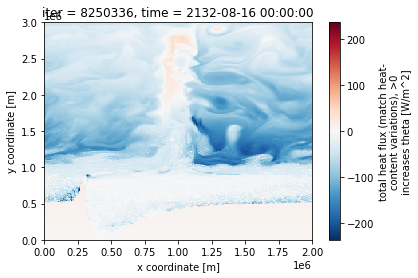

In [21]:
ds_2d['TFLUX'].sel(time=ds_2d['time'][-1]).plot()

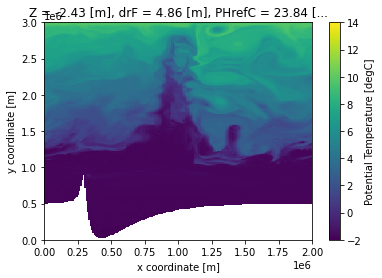

In [26]:
ds_state['THETA'].where(ds_state['SALT']>0).sel(Z=0, method='nearest').sel(time=ds_state['time'][-1], method='nearest').plot(vmin=-2, vmax=14)

In [27]:
def plot_temperature(i, xloc):
    fig, ax = plt.subplots(1,3, figsize=(18,4))
    
    ds_state['THETA'].where(ds_state['SALT']>0).sel(XC=xloc, method='nearest').sel(time=ds_state['time'][i], method='nearest').plot(ax=ax[0],
                                                                                                          vmin=-2, vmax=10,
                                                                                                         cmap=cmocean.cm.thermal)
    (-ds_2d['MXLDEPTH'].sel(XC=xloc, method='nearest').sel(time=ds_2d['time'][i])).plot(color='k', ax=ax[0])
    # ds_layers['LaTr3RHO'].where(ds_state['SALT']>0).mean(dim='XC').sel(time=ds_layers['time'][int(np.floor(i/72)-1)]).plot.contour(
    #                 levels=np.linspace(31,35,40), ax=ax[0])


    ds_2d['MXLDEPTH'].sel(time=ds_2d['time'][i]).plot.contour(ax=ax[1],
                                                             levels=[1,10,50,
                                                                     100,200,300,400,500,600,700,800,900,1000,
                                                                     1200,1400,1600,1800,2000])
    ds_state['THETA'].where(ds_state['SALT']>0).sel(Z=0, method='nearest').sel(time=ds_state['time'][i], method='nearest').plot(ax=ax[1],
                                                                                                      vmin=-2, vmax=10,
                                                                                                      cmap=cmocean.cm.thermal)
    ds_seaice['SI_Fract'].sel(time=ds_seaice['time'][i]).where(
            ds_seaice['SI_Fract'].sel(time=ds_seaice['time'][i])>0.15).plot(cmap='binary_r', ax=ax[1], vmin=0, vmax=1, zorder=3)


    ds_state['THETA'].where(ds_state['SALT']>0).sel(XC=xloc, method='nearest').sel(time=ds_state['time'][i], method='nearest').plot(ax=ax[2],
                                                                                                          vmin=-2, vmax=10,
                                                                                                         cmap=cmocean.cm.thermal)
    ax[2].set_ylim(-1500,0)
    # ds_layers['LaTr3RHO'].where(ds_state['SALT']>0).mean(dim='XC').sel(time=ds_layers['time'][int(np.floor(i/72)-1)]).plot.contour(
    #                 levels=np.linspace(31,35,40), ax=ax[2])
    (-ds_2d['MXLDEPTH'].sel(XC=xloc, method='nearest').sel(time=ds_2d['time'][i])).plot(color='k', ax=ax[2])





In [61]:
t_max = min(ds_state['time'].shape[0]-1, ds_2d['time'].shape[0]-1)

ipywidgets.interactive(plot_temperature,
                       i=ipywidgets.IntSlider(value=t_max, min=0,max=t_max),
                       xloc=ipywidgets.FloatSlider(value=400e3, min=0,max=1e6, step=10e3))

interactive(children=(IntSlider(value=719, description='i', max=719), FloatSlider(value=400000.0, description=…

In [62]:
heat = grid.average(ds_state['THETA'].where(ds_state['SALT']>0), ['X','Y'])

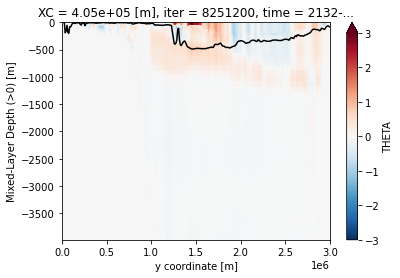

In [64]:
# change in temperature
xloc = 400e3
(ds_state['THETA'].sel(XC=xloc, method='nearest').sel(time=ds_state['time'][-1], method='nearest') - 
    ds_state['THETA'].sel(XC=xloc, method='nearest').sel(time=ds_state['time'][0], method='nearest')).plot(vmin=-3, vmax=3, cmap='RdBu_r')
(-ds_2d['MXLDEPTH'].sel(XC=xloc, method='nearest').sel(time=ds_2d['time'][-1])).plot(color='k')



In [65]:
def plot_salinity(i, xloc):
    fig, ax = plt.subplots(1,3, figsize=(18,4))
    
    ds_state['SALT'].where(ds_state['SALT']>0).sel(XC=xloc, method='nearest').sel(time=ds_state['time'][i], method='nearest').plot(ax=ax[0],
                                                                                                          vmin=34, vmax=35,
                                                                                                         cmap=cmocean.cm.haline)
    # ds_layers['LaTr3RHO'].where(ds_state['SALT']>0).mean(dim='XC').sel(time=ds_layers['time'][int(np.floor(i/72))-1]).plot.contour(
    #                 levels=np.linspace(31,35,40), ax=ax[0])
    (-ds_2d['MXLDEPTH'].sel(XC=xloc, method='nearest').sel(time=ds_2d['time'][i])).plot(color='k', ax=ax[0])


    
    ds_2d['MXLDEPTH'].sel(time=ds_2d['time'][i]).plot.contour(ax=ax[1],
                                                             levels=[1,10,50,
                                                                     100,200,300,400,500,600,700,800,900,1000,
                                                                     1200,1400,1600,1800,2000])
    ds_state['SALT'].where(ds_state['SALT']>0).sel(Z=0, method='nearest').sel(time=ds_state['time'][i], method='nearest').plot(ax=ax[1],
                                                                                                      vmin=34, vmax=35,
                                                                                                      cmap=cmocean.cm.haline)
    ds_seaice['SI_Fract'].sel(time=ds_seaice['time'][i]).where(
            ds_seaice['SI_Fract'].sel(time=ds_seaice['time'][i])>0.15).plot(cmap='binary_r', ax=ax[1], vmin=0, vmax=1, zorder=3)


    ds_state['SALT'].where(ds_state['SALT']>0).mean(dim='XC').sel(time=ds_state['time'][i], method='nearest').plot(ax=ax[2],
                                                                                                          vmin=34, vmax=35,
                                                                                                         cmap=cmocean.cm.haline)


    # ds_layers['LaTr3RHO'].where(ds_state['SALT']>0).mean(dim='XC').sel(time=ds_layers['time'][int(np.floor(i/72))-1]).plot.contour(
    #                 levels=np.linspace(31,35,40), ax=ax[2])

    (-ds_2d['MXLDEPTH'].mean(dim='XC').sel(time=ds_2d['time'][i])).plot(color='k', ax=ax[2])
    ax[2].set_ylim(-1000,0)


In [66]:
t_max = min(ds_state['time'].shape[0]-1, ds_2d['time'].shape[0]-1)

ipywidgets.interactive(plot_salinity,
                       i=ipywidgets.IntSlider(value=t_max, min=0,max=t_max),
                       xloc=ipywidgets.FloatSlider(value=400e3, min=0,max=1e6, step=10e3))

interactive(children=(IntSlider(value=719, description='i', max=719), FloatSlider(value=400000.0, description=…

In [67]:
salinity = grid.average(ds_state['SALT'].where(ds_state['SALT']>0), ['X','Y'])



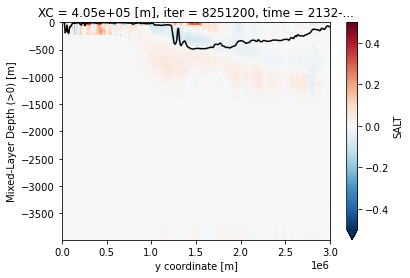

In [69]:
# change in salinity
xloc = 400e3
(ds_state['SALT'].sel(XC=xloc, method='nearest').sel(time=ds_state['time'][-1], method='nearest') - 
    ds_state['SALT'].sel(XC=xloc, method='nearest').sel(time=ds_state['time'][0], method='nearest')).plot(vmin=-.5, vmax=.5, cmap='RdBu_r')
(-ds_2d['MXLDEPTH'].sel(XC=xloc, method='nearest').sel(time=ds_2d['time'][-1])).plot(color='k')

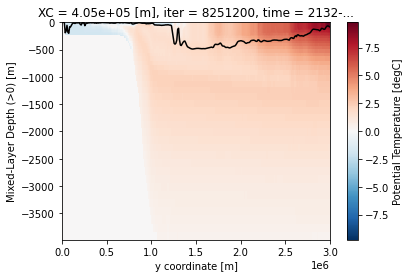

In [70]:
xloc = 400e3
ds_state['THETA'].sel(XC=xloc, method='nearest').sel(time=ds_state['time'][-1], method='nearest').plot()
(-ds_2d['MXLDEPTH'].sel(XC=xloc, method='nearest').sel(time=ds_2d['time'][-1])).plot(color='k')

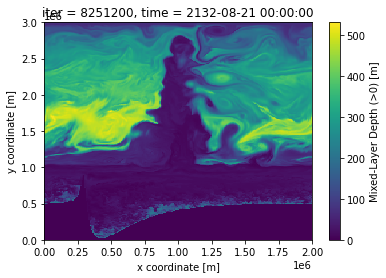

In [71]:
ds_2d['MXLDEPTH'].sel(time=ds_2d['time'][-1], method='nearest').plot()

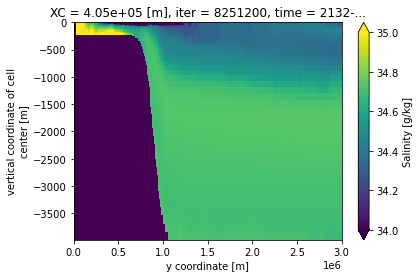

In [72]:
ds_state['SALT'].sel(XC=400e3, method='nearest').sel(time=ds_state['time'][-1], method='nearest').plot(vmin=34, vmax=35)

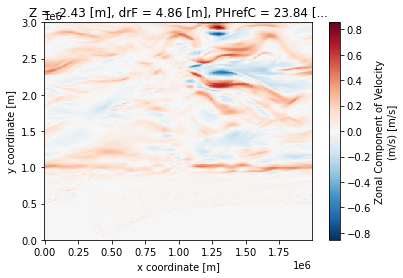

In [73]:
ds_state['UVEL'].sel(Z=0, method='nearest').sel(time=ds_state['time'][-1]).plot()

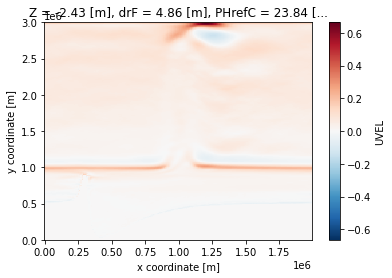

In [74]:
ds_state['UVEL'].sel(Z=0, method='nearest').sel(time=slice('2022-01-01',ds_state['time'][-1])).mean(dim='time').plot()

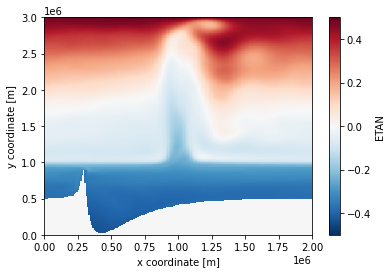

In [75]:
ds_2d['ETAN'].sel(time=slice('2022-01-01',ds_2d['time'][-1])).mean(dim='time').plot()

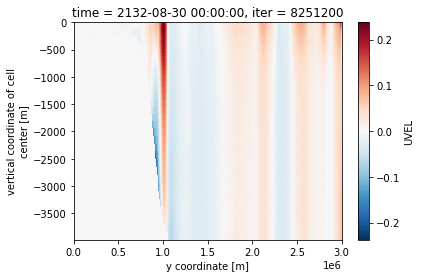

In [76]:
ds_state['UVEL'].resample(time="1M").mean().mean(dim='XG').sel(time=ds_state['time'][-1], method='nearest').plot()

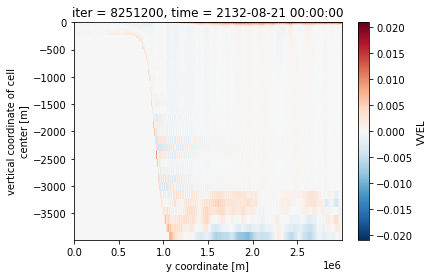

In [77]:
ds_state['VVEL'].mean(dim='XC').sel(time=ds_state['time'][-1]).plot()

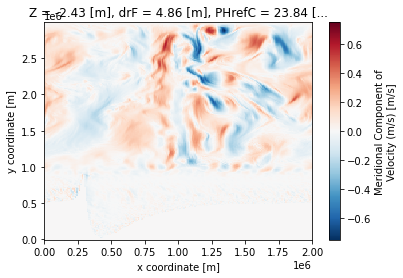

In [78]:
ds_state['VVEL'].sel(Z=0, method='nearest').sel(time=ds_state['time'][-1]).plot()

## Transport

## Sea Ice

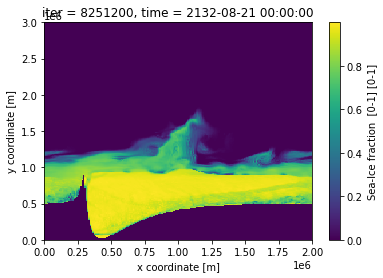

In [79]:
ds_seaice['SI_Fract'].sel(time=ds_seaice['time'][-1]).plot()

In [80]:
sea_ice_time_series = grid.integrate(ds_seaice['SI_Fract'], ['X', 'Y'])/1e12 # in millions of square km

## vorticity

## Layers


## Calculate layerwise fluxes using the 5 day snapshots
Define density, regrid `VVEL`, `THETA`, and `ADVy_TH` into density space. Need to multipy `VVEL` and `THETA` by `drF` to make themm extensive quantities. Also regrid an array of `drF` to get the thickness.

In [22]:
time_range = (ds_state['time'][-720], ds_state['time'][-1])
time_range

(<xarray.DataArray 'time' ()>
 array(cftime.Datetime360Day(2122, 8, 21, 0, 0, 0, 0, has_year_zero=True),
       dtype=object)
 Coordinates:
     iter     int64 dask.array<chunksize=(), meta=np.ndarray>
     time     object 2122-08-21 00:00:00
 Attributes:
     standard_name:  time
     long_name:      Time
     axis:           T,
 <xarray.DataArray 'time' ()>
 array(cftime.Datetime360Day(2132, 8, 16, 0, 0, 0, 0, has_year_zero=True),
       dtype=object)
 Coordinates:
     iter     int64 dask.array<chunksize=(), meta=np.ndarray>
     time     object 2132-08-16 00:00:00
 Attributes:
     standard_name:  time
     long_name:      Time
     axis:           T)

In [23]:
mask_TP = xr.where(ds_state['hFacC']>0, 1, 0)

mask_VP = xr.where(ds_state['hFacS']>0, 1, 0)

In [114]:
sigma2 = gsw.density.sigma2(ds_state['SALT'].where(mask_TP),
                            ds_state['THETA'].where(mask_TP))



In [115]:
#move to required location for interpolation
sigma2 = grid.interp(sigma2, 'Y', boundary='extend')
sigma2.name = 'sigma2'


sigma2_zp1 = grid.interp(sigma2, 'Z', boundary='extend', to='outer')
sigma2_zp1.name = 'sigma2'




In [116]:
sigma2_bar = sigma2.sel(time=slice(time_range[0], time_range[1])).mean(dim='time').compute()
sigma2_zp1_bar = grid.interp(sigma2_bar, 'Z', boundary='extend', to='outer')

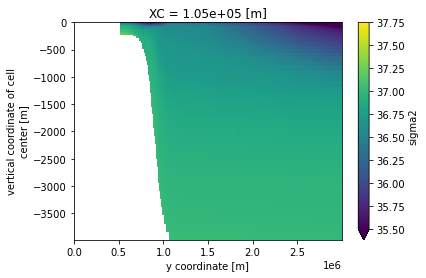

In [117]:
sigma2_bar.sel(XC=0.1e6, method='nearest').plot(vmin=35.5, vmax=37.75)

In [242]:
sigma2_layer_bounds = np.append(np.linspace(31.5,36.8, 53, endpoint=False), np.linspace(36.8, 36.95,3, endpoint=False))
sigma2_layer_bounds = np.append(sigma2_layer_bounds, np.linspace(36.95, 37.1, 6, endpoint=False))
sigma2_layer_bounds = np.append(sigma2_layer_bounds, np.linspace(37.1, 38, 10))

# sigma2_layer_bounds = np.linspace(31.5, 38, 131)
# sigma2_layer_bounds = sigma2_layer_bounds[::-1]

# sigma2_layer_bounds = np.linspace(31.5,38, 261)

sigma2_layer_midpoints = (sigma2_layer_bounds[1:] + sigma2_layer_bounds[:-1])/2

sigma2_layer_bounds

array([31.5  , 31.6  , 31.7  , 31.8  , 31.9  , 32.   , 32.1  , 32.2  ,
       32.3  , 32.4  , 32.5  , 32.6  , 32.7  , 32.8  , 32.9  , 33.   ,
       33.1  , 33.2  , 33.3  , 33.4  , 33.5  , 33.6  , 33.7  , 33.8  ,
       33.9  , 34.   , 34.1  , 34.2  , 34.3  , 34.4  , 34.5  , 34.6  ,
       34.7  , 34.8  , 34.9  , 35.   , 35.1  , 35.2  , 35.3  , 35.4  ,
       35.5  , 35.6  , 35.7  , 35.8  , 35.9  , 36.   , 36.1  , 36.2  ,
       36.3  , 36.4  , 36.5  , 36.6  , 36.7  , 36.8  , 36.85 , 36.9  ,
       36.95 , 36.975, 37.   , 37.025, 37.05 , 37.075, 37.1  , 37.2  ,
       37.3  , 37.4  , 37.5  , 37.6  , 37.7  , 37.8  , 37.9  , 38.   ])

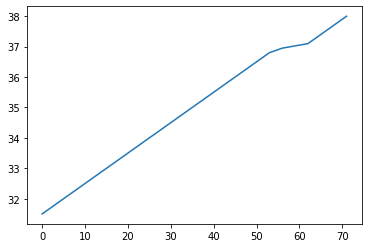

In [243]:
plt.plot(sigma2_layer_bounds)

In [120]:
# define time mean vvel at constant depth
vbar = ds_state['VVEL'].sel(time=slice(time_range[0], time_range[1])).mean(dim=['time']).compute()


In [121]:
meridional_volume_flux = ds_state['VVEL']*ds_state['drF']*ds_state['dxG']*ds_state['hFacS']
heat_content = grid.interp(ds_state['THETA']*ds_state['drF']*ds_state['hFacC'], 'Y', boundary='extend')
vertical_coordinate = xr.ones_like(ds_state['VVEL'])*ds_state['drF']

## Overturning circulations

'Residual', or total, overturning
$$
\Psi = \frac{1}{T}\int_{0}^{T} \oint \sum_{i = 1}^{N} v(x,y,\sigma_{2i})h(x,y,\sigma_{2i}) dx dt
$$

Eulerian-mean overturning
$$
\overline{\Psi} = \oint \sum_{i=1}^{N} \overline{v}(x,y,\sigma_{2i})\overline{h}(x,y,\sigma_{2i}) dx
$$

Transient eddy overturning
$$
\Psi^{*} = \Psi - \overline{\Psi}
$$

Could also define the transient eddy overturning by defining $v'$, and $h'$, but numerically this doesn't work so well.

Now, we want to break the Eulerian-mean overturning into standing meander and zonal-mean components.

Zonal-mean Eulerian-mean overturning
$$
<\Psi> = L \sum_{i=1}^{N} <\overline{v}>(y,\sigma_{2i}) <\overline{h}>(y,\sigma_{2i})
$$

Standing meander Eulerian-mean overturning
$$
\Psi_{SM} = \overline{\Psi} - <\Psi>
$$

In [31]:
from xhistogram.xarray import histogram


In [32]:
def cumsum_from_bottom (transposrts, dim='sigma2'):
    cumsum= (transposrts.cumsum(dim)-transposrts.sum(dim))
    return cumsum

In [244]:
layerwise_merid_vol_flux = histogram(sigma2, 
                          bins=[sigma2_layer_bounds], 
                          dim = ['Z'],
                          weights=meridional_volume_flux).rename({'sigma2_bin':'sigma2'})



In [245]:
%%time
psi = layerwise_merid_vol_flux.mean(dim='time').compute().rename('psi')

distributed.utils - ERROR - 'str' object has no attribute 'text'
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/distributed/utils.py", line 681, in log_errors
    yield
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/distributed/dashboard/components/scheduler.py", line 2729, in update
    self.root.title.text = (
AttributeError: 'str' object has no attribute 'text'
distributed.utils - ERROR - 'str' object has no attribute 'text'
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/distributed/utils.py", line 681, in log_errors
    yield
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/distributed/dashboard/components/scheduler.py", line 3203, in individual_doc
    fig.update()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/pytho

CPU times: user 1min 25s, sys: 4.61 s, total: 1min 29s
Wall time: 2min 2s


In [246]:
psi_bar = histogram(sigma2_bar, 
                          bins=[sigma2_layer_bounds], 
                          dim = ['Z'],
                          weights=vbar*ds_state['drF']*ds_state['dxG']*
                                    ds_state['hFacS']).rename({'sigma2_bin':'sigma2'}).rename('psi_bar')


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask/array/core.py:1593: FutureWarning: The `numpy.histogram_bin_edges` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


In [247]:
hbar = histogram(sigma2_bar, 
                          bins=[sigma2_layer_bounds], 
                          dim = ['Z'],
                          weights=xr.ones_like(vbar)*ds_state['drF']).rename({'sigma2_bin':'sigma2'}).rename('hbar')



XL = np.tile(ds_state['YG'], (len(sigma2_layer_bounds)-1,1)).T


YL = -hbar.mean(dim=['XC']).cumsum(dim='sigma2').compute()




/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask/array/core.py:1593: FutureWarning: The `numpy.histogram_bin_edges` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


In [248]:
# psi = layerwise_merid_vol_flux.sel(time=slice(time_range[0], time_range[1])).mean(dim='time').compute()

# # this uses time-mean of the layer velocities and thickness. Should instead use Eulerian-mean in depth, and then convert to layer
# # psi_bar = (layerwise_vbar*layerwise_hbar*ds_state['dxG']).compute()

# psi_bar = (vbar_converted_to_layers*hbar_converted_to_layers*ds_state['dxG']).compute()


psi_star = psi - psi_bar

Text(0.5, 1.0, '$\\Psi^{*}$')

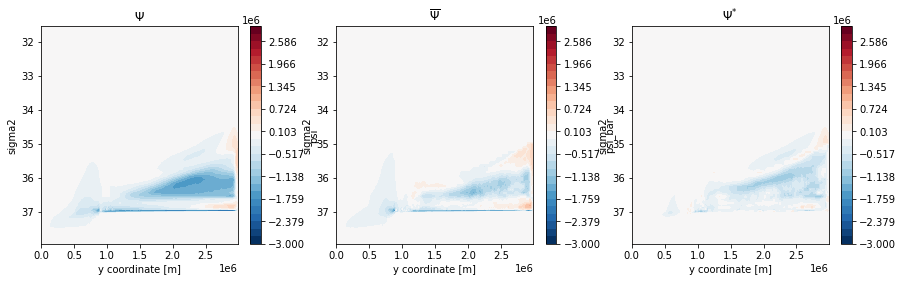

In [249]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
levels=np.linspace(-3,3,30,)*1e6

cumsum_from_bottom(psi.sum(dim='XC')).plot.contourf(ax=ax[0], y='sigma2', yincrease=False, robust=True, levels=levels)
ax[0].set_title('$\Psi$')

cumsum_from_bottom(psi_bar.sum(dim='XC')).plot.contourf(ax=ax[1], y='sigma2', yincrease=False, robust=True, levels=levels)
ax[1].set_title('$\overline{\Psi}$')


cumsum_from_bottom(psi_star.sum(dim='XC')).plot.contourf(ax=ax[2], y='sigma2', yincrease=False, robust=True, levels=levels)
ax[2].set_title('$\Psi^{*}$')




Text(0.5, 1.0, '$\\Psi^{*}$')

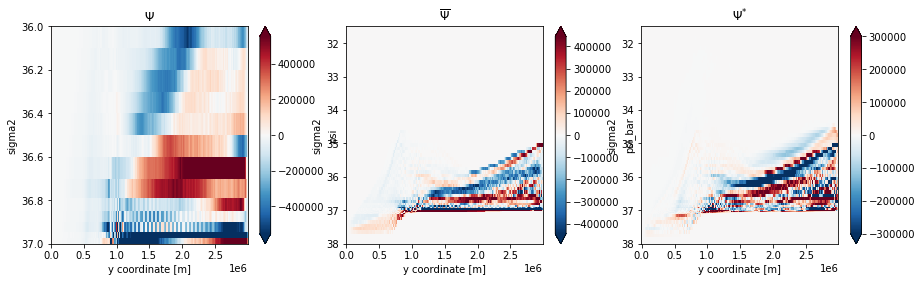

In [250]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

(psi.sum(dim='XC')).plot(ax=ax[0], y='sigma2', yincrease=False, robust=True)
ax[0].set_title('$\Psi$')
ax[0].set_ylim(37,36)

(psi_bar.sum(dim='XC')).plot(ax=ax[1], y='sigma2', yincrease=False, robust=True)
ax[1].set_title('$\overline{\Psi}$')


(psi_star.sum(dim='XC')).plot(ax=ax[2], y='sigma2', yincrease=False, robust=True)
ax[2].set_title('$\Psi^{*}$')





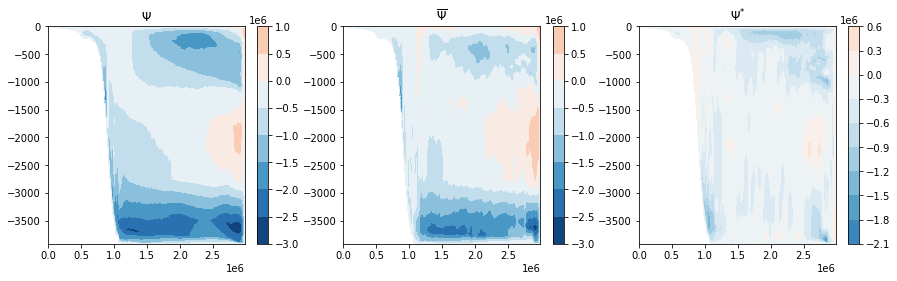

In [251]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

im = ax[0].contourf(XL, YL, cumsum_from_bottom(psi.sum(dim='XC')), cmap='RdBu_r', vmin=-3e6, vmax=3e6)
ax[0].set_title('$\Psi$')
plt.colorbar(im, ax=ax[0])

im2 = ax[1].contourf(XL, YL, cumsum_from_bottom(psi_bar.sum(dim='XC')), cmap='RdBu_r', vmin=-3e6, vmax=3e6)
ax[1].set_title('$\overline{\Psi}$')
plt.colorbar(im2, ax=ax[1])

im3 = ax[2].contourf(XL, YL, cumsum_from_bottom(psi_star.sum(dim='XC')), cmap='RdBu_r', vmin=-3e6, vmax=3e6)
ax[2].set_title('$\Psi^{*}$')
plt.colorbar(im3, ax=ax[2])

# blue rotates counter-clockwise


/local/hh5/ed7737/tmp/ipykernel_1066162/4166828815.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax[0].pcolormesh(XL, YL, psi.mean(dim='XC'), cmap='RdBu_r', vmin=-5e3, vmax=5e3)
/local/hh5/ed7737/tmp/ipykernel_1066162/4166828815.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im2 = ax[1].pcolormesh(XL, YL, psi_bar.mean(dim='XC'), cmap='RdBu_r', vmin=-5e3, vmax=5e3)
/local/hh5/ed7737/tmp/ipykernel_1066162/4166828815.py:11: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead

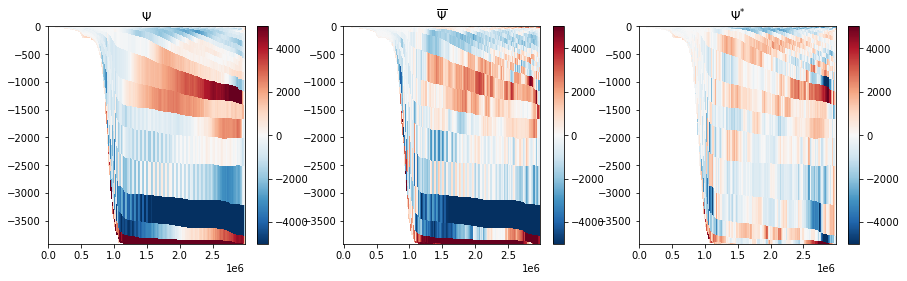

In [252]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

im = ax[0].pcolormesh(XL, YL, psi.mean(dim='XC'), cmap='RdBu_r', vmin=-5e3, vmax=5e3)
ax[0].set_title('$\Psi$')
plt.colorbar(im, ax=ax[0])

im2 = ax[1].pcolormesh(XL, YL, psi_bar.mean(dim='XC'), cmap='RdBu_r', vmin=-5e3, vmax=5e3)
ax[1].set_title('$\overline{\Psi}$')
plt.colorbar(im2, ax=ax[1])

im3 = ax[2].pcolormesh(XL, YL, psi_star.mean(dim='XC'), cmap='RdBu_r', vmin=-5e3, vmax=5e3)
ax[2].set_title('$\Psi^{*}$')
plt.colorbar(im3, ax=ax[2])




### Calculate Standing meander overturning using Dufour et al. (2012) method
Define time average, zonal average $v$
Define time average, zonal averagh $h$
Compute $\Psi_{zm}$ from these. Get $\Psi_{sm}$ by difference.

In [253]:
# psi_zm  = xr.ones_like(layerwise_vbar)*((layerwise_vbar*ds_state['dxG']).mean(dim='XC')*layerwise_hbar.mean(dim='XC')).compute()
psi_zm = xr.ones_like(psi_bar)*histogram(sigma2_bar.mean(dim='XC'), 
                                          bins=[sigma2_layer_bounds], 
                                          dim = ['Z'],
                                          weights=(vbar*ds_state['drF']*ds_state['dxG']
                                                   *ds_state['hFacS']).mean(dim='XC')).rename(
                                                {'sigma2_bin':'sigma2'}).rename('psi_zm')






psi_zp = psi_bar - psi_zm


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask/array/core.py:1593: FutureWarning: The `numpy.histogram_bin_edges` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


Text(0.5, 1.0, '$\\Psi_{zp}$ - zonal perturbation')

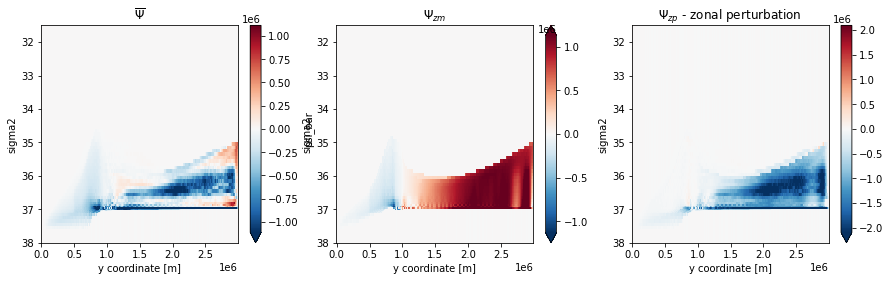

In [254]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

cumsum_from_bottom(psi_bar.sum(dim='XC')).plot(ax=ax[0], y='sigma2', yincrease=False, robust=True)
ax[0].set_title('$\overline{\Psi}$')

cumsum_from_bottom(psi_zm.sum(dim='XC')).plot(ax=ax[1], y='sigma2', yincrease=False, robust=True)
ax[1].set_title('$\Psi_{zm}$')


cumsum_from_bottom(psi_zp.sum(dim='XC')).plot(ax=ax[2], y='sigma2', yincrease=False, robust=True)
ax[2].set_title('$\Psi_{zp}$ - zonal perturbation')





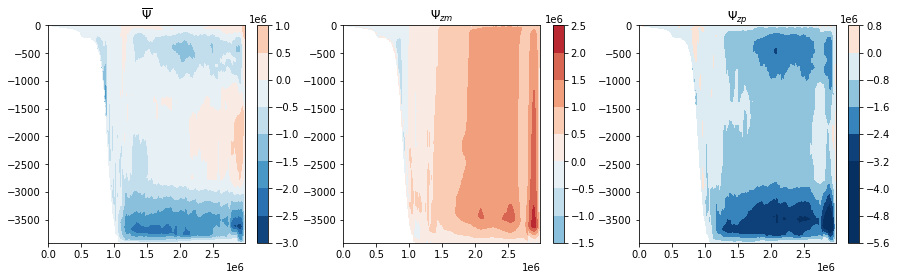

In [255]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

im = ax[0].contourf(XL, YL, cumsum_from_bottom(psi_bar.sum(dim='XC')), cmap='RdBu_r', vmin=-3e6, vmax=3e6)
ax[0].set_title('$\overline{\Psi}$')
plt.colorbar(im, ax=ax[0])

im2 = ax[1].contourf(XL, YL, cumsum_from_bottom(psi_zm.sum(dim='XC')), cmap='RdBu_r', vmin=-3e6, vmax=3e6)
ax[1].set_title('$\Psi_{zm}$')
plt.colorbar(im2, ax=ax[1])

im3 = ax[2].contourf(XL, YL, cumsum_from_bottom(psi_zp.sum(dim='XC')), cmap='RdBu_r', vmin=-3e6, vmax=3e6)
ax[2].set_title('$\Psi_{zp}$')
plt.colorbar(im3, ax=ax[2])


# blue rotates counter-clockwise



/local/hh5/ed7737/tmp/ipykernel_1066162/1269642163.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax[0].pcolormesh(XL, YL, psi_bar.mean(dim='XC'), cmap='RdBu_r', vmin=-5e3, vmax=5e3)
/local/hh5/ed7737/tmp/ipykernel_1066162/1269642163.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im2 = ax[1].pcolormesh(XL, YL, psi_zm.mean(dim='XC'), cmap='RdBu_r', vmin=-5e3, vmax=5e3)
/local/hh5/ed7737/tmp/ipykernel_1066162/1269642163.py:11: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may l

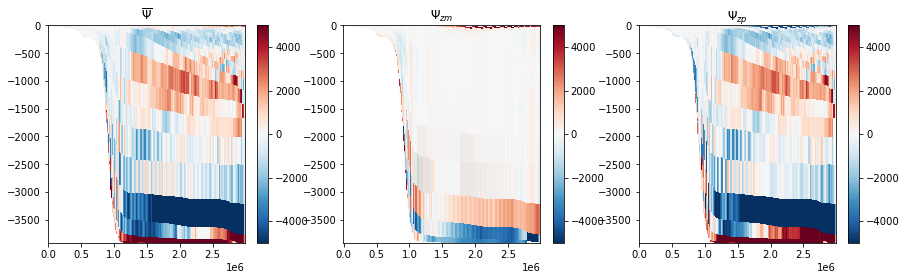

In [256]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

im = ax[0].pcolormesh(XL, YL, psi_bar.mean(dim='XC'), cmap='RdBu_r', vmin=-5e3, vmax=5e3)
ax[0].set_title('$\overline{\Psi}$')
plt.colorbar(im, ax=ax[0])

im2 = ax[1].pcolormesh(XL, YL, psi_zm.mean(dim='XC'), cmap='RdBu_r', vmin=-5e3, vmax=5e3)
ax[1].set_title('$\Psi_{zm}$')
plt.colorbar(im2, ax=ax[1])

im3 = ax[2].pcolormesh(XL, YL, psi_zp.mean(dim='XC'), cmap='RdBu_r', vmin=-5e3, vmax=5e3)
ax[2].set_title('$\Psi_{zp}$')
plt.colorbar(im3, ax=ax[2])


# blue means southward flow




## Heat transport

Use the framework from Naviero Garabato et al. (2017):

$$
T(C) = \int_{0}^{L}\sum_{i=1}^{N} v(x,y,i,t) h(x,y,i,t) C(x,y,i,t) ds,
$$

where $L$ is the length of the face through the flux is transported, $v$ is the velocity normal to the face, $h$ is the layer thickness, $C$ is the tracer concentration, $i$ is the layer, and there are $N$ layers in total.


We can break this up into advective and diffusive contributions. We can then further break up the advective contribution into zonal-mean and standing meander.

Test heat flux in standing meanders - is it eddy diffusion that does the work, standing meander fluxes, or zonal mean fluxes?

Define zonal mean as $<\cdot>$, zonal perturbation as $\tilde{\cdot}$, time-mean as $\overline{\cdot}$, and time perturbation as $\cdot'$.

Now we can time-average and expand $T(C)$ into different terms.

$$
\overline{T}(C) = \int_{0}^{L}\sum_{i=1}^{N} \left(\overline{v} \overline{h} + \overline{v' h'}\right) \overline{C} ds + \int_{0}^{L}\sum_{i=1}^{N} \overline{(vh)' C'} ds,
$$

where the first term is the flux due to advection of the time-mean tracer by the overturning circulation and the second term is the flux due to eddy diffusion. The advective flux includes contributions from the time-mean overturning, $\overline{v} \overline{h}$, and the eddy-induced overturning, $\overline{v' h'}$. The time-mean overturning can be further broken down into zonal-mean and zonal-perturbation components.

$$
\overline{T}(C) = \int_{0}^{L}\sum_{i=1}^{N} \left(<\overline{v}> <\overline{h}> + \overline{\tilde{v}} \overline{\tilde{h}} \right) (<\overline{C}> + \overline{\tilde{C}}) + \overline{v' h'} \overline{C} ds + \int_{0}^{L}\sum_{i=1}^{N} \overline{(vh)' C'} ds,
$$

Expanding terms and removing single perturbation terms, which integrate to zero, gives

$$
\overline{T}(C) = \int_{0}^{L}\sum_{i=1}^{N} \left(<\overline{v}> <\overline{h}> <\overline{C}>  + \overline{\tilde{v}} \overline{\tilde{h}} \right) (<\overline{C}> + \overline{\tilde{C}}) + \overline{v' h'} \overline{C} ds + \int_{0}^{L}\sum_{i=1}^{N} \overline{(vh)' C'} ds,
$$



$$
\overline{T}(C) = \int_{0}^{L}\sum_{i=1}^{N} \left(<\overline{v}> <\overline{h}> <\overline{C}>  + \overline{\tilde{v}} \overline{\tilde{h}} \right) <\overline{C}> + \widetilde{(\overline{v}\overline{h})}\tilde{\overline{C}} + \overline{v' h'} \overline{C} ds + \int_{0}^{L}\sum_{i=1}^{N} \overline{(vh)' C'} ds,
$$

$$
T(C) = <\overline{\Psi}><\overline{C}> + \Psi_{sm}\overline{C} + \Psi^{*}\overline{C} + \overline{(vh)'C'}
$$

In [257]:
vh_prime = (layerwise_merid_vol_flux.sel(time=slice(time_range[0], time_range[1])) - psi)

# Need to use the linear transformation from xgcm for temperature, since it is not an
# extensive property. Using xhistogram results in some weird values.

# layerwise_temperature = histogram(sigma2, 
#                           bins=[sigma2_layer_bounds], 
#                           dim = ['Z'],
#                           weights=grid.interp(ds_state['THETA'], 'Y',
#                                               boundary='extend')).rename({'sigma2_bin':'sigma2'})

# linear interpolation from xgcm

layerwise_temperature = grid.transform(grid.interp(ds_state['THETA'], 'Y', boundary='extend'),
                                          'Z',
                                          sigma2_layer_midpoints,
                                          method='linear',
                                          target_data=sigma2,
                                       mask_edges=False)

In [258]:
vhc_reconstructed = layerwise_merid_vol_flux*layerwise_temperature
vhc_reconstructed_bar = vhc_reconstructed.mean(dim='time').compute()

In [259]:
# layerwise_Tbar = layerwise_temperature.sel(time=slice(time_range[0], time_range[1])).mean(dim='time').compute()

# converting the Eulerian-mean temperature field into layers is inconsistent with the idea of layerwise fluxes.
layerwise_Tbar = grid.transform(grid.interp(ds_state['THETA'].mean(dim='time'), 'Y', boundary='extend'),
                                          'Z',
                                          sigma2_layer_midpoints,
                                          method='linear',
                                          target_data=sigma2_bar,
                                       mask_edges=False).compute()

In [260]:

Tprime = layerwise_temperature - layerwise_Tbar

# eddy transport
vh_prime_Tprime_bar = (vh_prime*Tprime).mean(dim='time').compute()


distributed.utils - ERROR - 'str' object has no attribute 'text'
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/distributed/utils.py", line 681, in log_errors
    yield
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/distributed/dashboard/components/scheduler.py", line 2729, in update
    self.root.title.text = (
AttributeError: 'str' object has no attribute 'text'
distributed.utils - ERROR - 'str' object has no attribute 'text'
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/distributed/utils.py", line 681, in log_errors
    yield
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/distributed/dashboard/components/scheduler.py", line 3203, in individual_doc
    fig.update()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/pytho

In [261]:
# Advective heat transport
psi_Tbar = psi*layerwise_Tbar

# is made up of Eulerian-mean and eddy

# Eulerian-mean overturning heat transport
psibar_Tbar = psi_bar*layerwise_Tbar
    # is made up of
    # zonal-mean
psizm_Tbar = psi_zm*layerwise_Tbar
    # standing meander
psizp_Tbar = psi_zp*layerwise_Tbar


# eddy overturning heat ransport
psistar_Tbar = psi_star*layerwise_Tbar


In [262]:
layerwise_heat_advection = histogram(sigma2, 
                          bins=[sigma2_layer_bounds], 
                          dim = ['Z'],
                          weights=ds_heat['ADVy_TH']).rename({'sigma2_bin':'sigma2'})




In [263]:

vhc_bar = layerwise_heat_advection.sel(time=slice(time_range[0],
                                                  time_range[1])).mean(dim='time').compute()

### Basin wide averages - does this method work?
Yes!

In [ ]:
vhc_bar.sum(dim=['YG', 'XC']).plot(y='sigma2', yincrease=False, label='Total transport of heat')

vhc_reconstructed_bar.sum(dim=['YG', 'XC']).plot(y='sigma2', yincrease=False, label='Reconstructed total transport of heat')


plt.legend()

In [ ]:
# 15 june - new attempt
(psi_Tbar).sum(dim=['YG', 'XC']).plot(y='sigma2', yincrease=False, label='MOC advection of heat')
(vh_prime_Tprime_bar).sum(dim=['XC','YG']).plot(y='sigma2', yincrease=False, label='Eddy diffusion of heat')
vhc_bar.sum(dim=['YG', 'XC']).plot(y='sigma2', yincrease=False, label='Total transport of heat')

plt.legend()

In [ ]:
(psi_Tbar + vh_prime_Tprime_bar).sum(dim=['YG', 'XC']).plot(y='sigma2', yincrease=False, label='MOC advection + eddy diffusion of heat')
vhc_bar.sum(dim=['YG', 'XC']).plot(y='sigma2', yincrease=False, label='Total transport of heat')

plt.legend()

In [ ]:
(psi_Tbar).sum(dim=['YG', 'XC']).plot(y='sigma2', yincrease=False, label='MOC advection of heat')
(psibar_Tbar).sum(dim=['XC','YG']).plot(y='sigma2', yincrease=False, label='Eulerian-mean advection of heat')
psistar_Tbar.sum(dim=['YG', 'XC']).plot(y='sigma2', yincrease=False, label='Eddy overturning transport of heat')

plt.legend()

In [ ]:
(psibar_Tbar).sum(dim=['XC','YG']).plot(y='sigma2', yincrease=False, label='Eulerian-mean advection of heat')
psizm_Tbar.sum(dim=['YG', 'XC']).plot(y='sigma2', yincrease=False, label='Zonal-mean overturning transport of heat')

psizp_Tbar.sum(dim=['YG', 'XC']).plot(y='sigma2', yincrease=False, label='Standing meander overturning transport of heat')


plt.legend()

In [ ]:
(psi_Tbar).sum(dim=['YG', 'XC']).plot(y='sigma2', yincrease=False, label='MOC advection of heat')
(psibar_Tbar + psistar_Tbar).sum(dim=['XC','YG']).plot(y='sigma2', yincrease=False, label='Eulerian-mean + eddy advection of heat')

plt.legend()

### Zonal-mean plots - where is this transport happening?

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

vhc_bar.sum(dim='XC').plot(ax=ax[0], y='sigma2', yincrease=False, robust=True)
ax[0].set_title('$\overline{vhT}$')

psi_Tbar.sum(dim='XC').plot(ax=ax[1], y='sigma2', yincrease=False, robust=True)
ax[1].set_title('$\overline{vh} \overline{T}$')


vh_prime_Tprime_bar.sum(dim='XC').plot(ax=ax[2], y='sigma2', yincrease=False, robust=True)
ax[2].set_title("$(vh)' T'$")





In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

im = ax[0].pcolormesh(XL, YL, vhc_bar.sum(dim='XC'), cmap='RdBu_r', vmin=-2e6, vmax=2e6)
ax[0].set_title('Total heat transport')
plt.colorbar(im, ax=ax[0])

im2 = ax[1].pcolormesh(XL, YL, psi_Tbar.sum(dim='XC'), cmap='RdBu_r', vmin=-2e6, vmax=2e6)
ax[1].set_title('Advective heat transport')
plt.colorbar(im2, ax=ax[1])

im3 = ax[2].pcolormesh(XL, YL, vh_prime_Tprime_bar.sum(dim='XC'), cmap='RdBu_r', vmin=-2e6, vmax=2e6)
ax[2].set_title('Diffusive heat transport')
plt.colorbar(im3, ax=ax[2])



In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

im = ax[0].pcolormesh(XL, YL, psi_Tbar.sum(dim='XC'), cmap='RdBu_r', vmin=-2e6, vmax=2e6)
ax[0].set_title('Advective heat trans.')
plt.colorbar(im2, ax=ax[0])

im = ax[1].pcolormesh(XL, YL, psibar_Tbar.sum(dim='XC'), cmap='RdBu_r', vmin=-2e6, vmax=2e6)
ax[1].set_title('Eulerian-mean adv. heat trans.')
plt.colorbar(im, ax=ax[1])


im3 = ax[2].pcolormesh(XL, YL, psistar_Tbar.sum(dim='XC'), cmap='RdBu_r', vmin=-2e6, vmax=2e6)
ax[2].set_title('Eddy-induced adv. heat trans.')
plt.colorbar(im3, ax=ax[2])




In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

im = ax[0].pcolormesh(XL, YL, psibar_Tbar.sum(dim='XC'), cmap='RdBu_r', vmin=-2e6, vmax=2e6)
ax[0].set_title('Eulerian-mean adv. heat trans.')
plt.colorbar(im2, ax=ax[0])

im = ax[1].pcolormesh(XL, YL, psizm_Tbar.sum(dim='XC'), cmap='RdBu_r', vmin=-2e6, vmax=2e6)
ax[1].set_title('Zonal-mean adv. heat transport')
plt.colorbar(im, ax=ax[1])


im3 = ax[2].pcolormesh(XL, YL, psizp_Tbar.sum(dim='XC'), cmap='RdBu_r', vmin=-2e6, vmax=2e6)
ax[2].set_title('Zonal Perturbation adv. heat trans.')
plt.colorbar(im3, ax=ax[2])


### x-y plots on a density surface


In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

vhc_bar.sel(sigma2=35.8, method='nearest').plot(ax=ax[0], vmin=-5e5, vmax=5e5, cmap='RdBu_r')
ax[0].set_title('Total heat trans.')
# plt.colorbar(im2, ax=ax[0])


psi_Tbar.sel(sigma2=35.8, method='nearest').plot(ax=ax[1], vmin=-5e5, vmax=5e5, cmap='RdBu_r')
ax[1].set_title('Advective heat transport')


vh_prime_Tprime_bar.sel(sigma2=35.8, method='nearest').plot(ax=ax[2], vmin=-5e4, vmax=5e4, cmap='RdBu_r')
ax[2].set_title('Diffusive heat transport')





In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

vhc_bar.sum(dim='sigma2').plot(ax=ax[0], vmin=-2e7, vmax=2e7, cmap='RdBu_r')
ax[0].set_title('Total heat trans.')
# plt.colorbar(im2, ax=ax[0])
ax[0].set_aspect('equal')



psi_Tbar.sum(dim='sigma2').plot(ax=ax[1], vmin=-2e7, vmax=2e7, cmap='RdBu_r')
ax[1].set_title('Advective heat transport')
ax[1].set_aspect('equal')


# this is two order of magnitude smaller - shows up with vmin/vmax=2e5
vh_prime_Tprime_bar.sum(dim='sigma2').plot(ax=ax[2], vmin=-2e7, vmax=2e7, cmap='RdBu_r')
ax[2].set_title('Diffusive heat transport')
ax[2].set_aspect('equal')




## Heat and volume transport onto the shelf

Begin with tansport over lines of latitude. Given the geomtry, this may be enough to get a good estimate of meridional heat flux over an isobath.

In [ ]:
vhc_bar.sel(YG=0.85e6, method='nearest').sum(dim='XC').plot(y='sigma2', yincrease=False)
plt.ylim(37.5, 34)

In [ ]:
plt.plot(vhc_bar.sel(YG=0.85e6, method='nearest').sum(dim='XC'),
    -hbar.sel(YG=0.85e6, method='nearest').mean(dim='XC').cumsum(dim='sigma2'))
plt.vlines(0,-1200,0, colors='k')

In [ ]:
plt.pcolormesh(XL, YL, vhc_bar.sum(dim='XC'), vmin=-2e5, vmax=2e5, cmap='RdBu_r')
plt.xlim(0.6e6, 0.9e6)
plt.ylim(-1500, 50)
plt.colorbar()
# (-ds_state['Depth']).mean(dim='XC').plot(color='k')


In [ ]:
plt.plot(psi.sel(YG=0.8e6, method='nearest').sum(dim='XC'),
    -hbar.sel(YG=0.8e6, method='nearest').mean(dim='XC').cumsum(dim='sigma2'))
plt.vlines(0,-1200,0, colors='k')

In [ ]:
plt.pcolormesh(XL, YL, psi.sum(dim='XC'), vmin=-1e5, vmax=1e5, cmap='RdBu_r')
plt.xlim(0.6e6, 0.9e6)
plt.ylim(-1500, 50)
plt.colorbar()
# (-ds_state['Depth']).mean(dim='XC').plot(color='k')


In [ ]:
plt.contourf(XL, YL, cumsum_from_bottom(psi.sum(dim='XC')), vmin=-2e6, vmax=2e6, cmap='RdBu_r', levels=20)
plt.xlim(0.0e6, 0.9e6)
plt.ylim(-1500, 50)
plt.colorbar()
# (-ds_state['Depth']).mean(dim='XC').plot(color='k')



### Next steps: break the heat and volume transport down into the different terms

In [ ]:
# y = 0.83e6 is roughly the 1000m isobath
ds_state['Depth'].sel(YC=0.83e6, method='nearest').plot()

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

vhc_bar.sel(YG=0.83e6, method='nearest').plot(ax=ax[0], y='sigma2', yincrease=False, robust=True)#, vmin=-5e5, vmax=5e5, cmap='RdBu_r')
ax[0].set_title('Total heat trans.')
# plt.colorbar(im2, ax=ax[0])


psi_Tbar.sel(YG=0.83e6, method='nearest').plot(ax=ax[1], y='sigma2', yincrease=False, vmin=-15e2, vmax=15e2, cmap='RdBu_r')
ax[1].set_title('Advective heat transport')


vh_prime_Tprime_bar.sel(YG=0.83e6, method='nearest').plot(ax=ax[2], y='sigma2', yincrease=False, vmin=-15e2, vmax=15e2, cmap='RdBu_r')
ax[2].set_title('Diffusive heat transport')






In [ ]:
yloc = 2e6

fig, ax = plt.subplots(1,3, figsize=(15,4))

vhc_bar.sel(YG=yloc, method='nearest').plot(ax=ax[0], y='sigma2', yincrease=False, robust=True)# vmin=-15e2, vmax=15e2, cmap='RdBu_r')
ax[0].set_title('Total heat trans.')
# plt.colorbar(im2, ax=ax[0])


psi_Tbar.sel(YG=yloc, method='nearest').plot(ax=ax[1], y='sigma2', yincrease=False, robust=True)# vmin=-15e2, vmax=15e2, cmap='RdBu_r')
ax[1].set_title('Advective heat transport')


vh_prime_Tprime_bar.sel(YG=yloc, method='nearest').plot(ax=ax[2], y='sigma2', yincrease=False, robust=True)# vmin=-15e2, vmax=15e2, cmap='RdBu_r')
ax[2].set_title('Diffusive heat transport')







In [ ]:
(vh_prime_Tprime_bar/vhc_bar).sel(YG=0.6e6, method='nearest').plot(y='sigma2', yincrease=False, vmin=-0.75, vmax=0.75, cmap='RdBu_r')
